# CNN: Aplicando Técnicas de Green Deep Learning

Nesse trabalho foi escolhido o dataset do CIFAKE, que contém um total de 140000 imagens, sendo 70000 que realmente fotram fotografadas e 70000 que foram geradas por um computador. O intuito é adaptar uma CNN já existente aplicando Fine Tunning em um modelo já existente, nesse caso o ResNet50, para classificar se essas imagens são genuínas (REAL) ou falsas (FAKE).

O dataset separa 100000 imagens para treino e 40000 para teste. Por limitações de processamento da máquina em que foi executado o modelo foram processadas apenas 10000 imagens para treino e 4000 para teste em duas épocas.

Os demais hiperparâmetros estão declarados no arquivo "globals.py".

## Download do Dataset

Essa etapa só é necessária caso o dataset ainda não esteja na máquina que está rodando. Depois de rodar esse bloco precisa copiar o caminho do diretório de onde está salvo o dataset e adicioná-lo nas variáveis globais (models/globals) em DATASET_PATH.

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

# print("Path to dataset files:", path)

## Instalando dependências

In [ ]:
# pip install ipykernel
# pip3 install torch torchvision torchaudio
# pip install matplotlib
# pip install scikit-learn
# pip install seaborn

## Imports

In [1]:
import torch
import torchvision
from torch import nn, optim
from torchvision import models, transforms
import os
import numpy as np

from modules import utils
from modules import globals
from modules.training_functions import train, validate
from torch.utils.data import Subset
import torch.nn.utils.prune as prune

## Visualizando e adaptando os dados

Afim de explorar o dataset exibimos 9 imagens do CIFAKE e treino e 9 de teste já transformadas para o padrão do ImageNet. Isso é feito porque ResNet18 foi treinado com esse padrão de imagem e para que ele performe bem no nosso dataset é necessário que a entrada possua as mesmas características gerais.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..1.5007002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.0091617].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.1345534].
Clipping

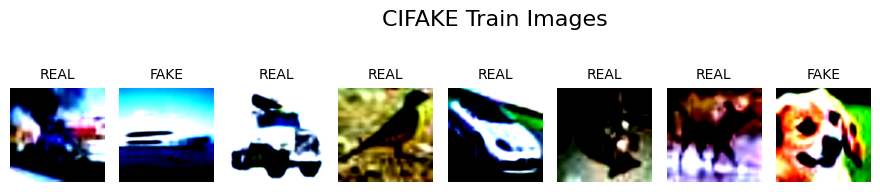

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..1.2556726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.1975338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.248

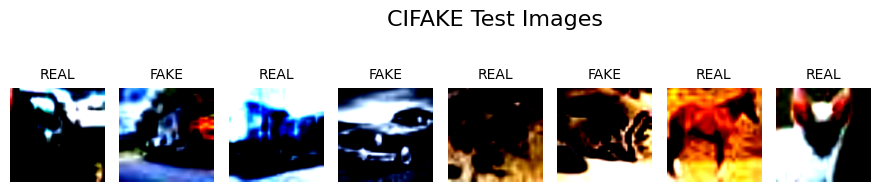

In [2]:
import random


transform = transforms.Compose([
                                     transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                  ])


transform_float16 = transforms.Compose([
    transform,
    lambda x: x.to(torch.float16)
])

train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'train'),
    transform=transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'test'),
    transform=transform
)

# Cria subsets para testar a lógica do modelo com um número menor do dataset (descomentar para usar)
subset_train_indices = list(range(globals.NUM_SAMPLES_TRAIN_DEBUGGER))
subset_test_indices = list(range(globals.NUM_SAMPLES_TEST_DEBUGGER))

total_train_samples = len(train_dataset)
num_train_to_select = min(globals.NUM_SAMPLES_TRAIN_DEBUGGER, total_train_samples)
subset_train_indices = random.sample(range(total_train_samples), num_train_to_select)

# Pega uma amostra aleatória de índices para o teste
total_test_samples = len(test_dataset)
num_test_to_select = min(globals.NUM_SAMPLES_TEST_DEBUGGER, total_test_samples)
subset_test_indices = random.sample(range(total_test_samples), num_test_to_select)

train_dataset_debugger = Subset(train_dataset, subset_train_indices)
test_dataset_debugger = Subset(test_dataset, subset_test_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset_debugger,
    batch_size=globals.BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset_debugger,
    batch_size=globals.BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

cross_entropy_function = nn.CrossEntropyLoss().to(globals.DEVICE)

utils.plot_sample(train_loader, "Train")
utils.plot_sample(test_loader, "Test")

## Fine-Tunning: ResNet18

Como dito anteriormente será realizado um Fine-tunning a partir da rede pré treinada ResNet50. Esse modelo foi treinado com o dataset do ImageNet e obteve ótimos resultados.

A principal inovação do ResNet é a utilização de conexões residuais. Dessa forma os problemas do "vanishing" ou "exploding" gradient são mitigados e possibilita um aprendizado mais rico, capaz de observar padrões complexos.

Para esse projeto é importante que a rede seja robusta, uma vez que a verficação de deepfakes não é uma tarefa simples. Por isso escolhemos a ResNet com 18 camadas ocultas.

In [5]:
model = models.resnet18(pretrained=True).to('cpu')
print(model)

c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Identificando e adaptando a camada fully connected (fc)

In [6]:
print(list(model.named_children())[-1])

('fc', Linear(in_features=512, out_features=1000, bias=True))


Precisamos substituir a fc do modelo, uma vez que a mesma possui uma classificação dos dados de entrada em 1000 classes. No caso do nosso problema, serão apenas duas: REAL e FAKE 

In [7]:
in_features = model.fc.in_features
print(f"Features: {in_features}")

num_classes_cifake = len(globals.CLASS_NAMES)

model.fc = nn.Linear(in_features, num_classes_cifake).to('cpu')

print(f"Nova camada FC: {model.fc}")

Features: 512
Nova camada FC: Linear(in_features=512, out_features=2, bias=True)


#### Fase 1: Treinamento apenas da camada fully connected

Na primeira fase do fine-tunning a ideia é congelar os parâmetros do modelo e ajustar apenas o da camada fortemente conectada.

In [ ]:
# Congelar todos os parâmetros do modelo
for param in model.parameters():
    param.requires_grad = False

# Descongelar apenas os parâmetros da nova camada 'fc'
for param in model.fc.parameters():
    param.requires_grad = True

# Otimizador para a Fase 1: Ele verá apenas os parâmetros que requires_grad=True
optimizer_phase1 = optim.Adam(model.fc.parameters(),
                              lr=globals.LEARNING_RATE_CLASSIFIER,
                              weight_decay=globals.WEIGHT_DECAY)

for epoch in range(globals.EPOCHS_FIRST_PHASE):
    print(f'\n ----------- Época [{epoch}] -----------')
    train(train_loader, model, optimizer_phase1, cross_entropy_function)
    validate(test_loader, model, cross_entropy_function)


 ----------- Época [0] -----------
1250/1250
Treino
Loss: 0.5211 +/- 0.3583, Acc: 76.57, Time: 921.83
500/500
Validação
Loss: 0.6232 +/- 0.4105, Acc: 74.92, Time: 365.95



#### Fase 2: Treinamento de todas as camadas

A segunda fase busca treinar a rede inteira, mas da menos importância ao ajuste das redes convolucionais. Essas são descongeladas, mas possuem um learning rate inferior ao da fully connected. Isso é feito para que ela mantenha o aprendizado robusto que foi obtido com o ImageNet e faça pequenos ajustes para o CIFAKE.

In [9]:
# Descongelar todos os parâmetros do modelo
for param in model.parameters():
    param.requires_grad = True

optimizer_phase2 = optim.Adam([
    # Geralmente uma LR um pouco menor que na Fase 1, mas maior que as features
    {'params': model.fc.parameters(), 'lr': globals.LEARNING_RATE_CLASSIFIER, 'weight_decay': globals.WEIGHT_DECAY},
    # Grupo 2: Parâmetros das camadas convolucionais (features)
    # LR muito baixa para ajustes sutis
    {'params': [p for name, p in model.named_parameters() if 'fc' not in name],
     'lr': globals.LEARNING_RATE_FEATURES, 'weight_decay': globals.WEIGHT_DECAY}
]) 

for epoch in range(globals.EPOCHS_SECOND_PHASE):
    print(f'\n----------- Época [{epoch + globals.EPOCHS_FIRST_PHASE}] -----------')
    # O número da época é ajustado para continuar da onde parou na fase anterior
    train(train_loader, model, optimizer_phase2, cross_entropy_function)
    validate(test_loader, model, cross_entropy_function)


----------- Época [1] -----------
13/1250

KeyboardInterrupt: 

### Salvando o Modelo

In [ ]:
model_path_float32 = "resnet18_cifake_finetuned_float32.pth"
torch.save(model.state_dict(), model_path_float32)
print(f"\nModelo original salvo em: {model_path_float32}")


Modelo original salvo em: resnet18_cifake_finetuned_float32.pth


## Estratégia escolhida: Prunning

Uma vez treinada a CNN original, o próximo passo é aplicar uma estratégia de IA Verde. Para isso foi aplicado a técnica de pruning (poda) para reduzir seu tamanho e, potencialmente, acelerar a inferência.

### Carregando modelo pré-treinado anteriormente

Carrega na memória o modelo original que performou o fina-tunning no ResNet18

In [ ]:
model = utils.load_model_from_file("resnet18_cifake_finetuned_float32.pth")
print("Modelo configurado para modo de avaliação.")


Modelo original 'resnet18_cifake_finetuned_float32.pth' carregado para avaliação de desempenho.
Modelo configurado para modo de avaliação.


### Executando a poda

Em seguida, são identificadas todas as camadas lineares (totalmente conectadas) e convolucionais que possuem pesos (parâmetros 'weight') e calculamos a esparsidade inicial de cada uma, que é a porcentagem de pesos iguais a zero. O  prune.L1Unstructured remove os 50% dos pesos com as menores magnitudes (valores mais próximos de zero) em todas as camadas especificadas, de forma não estruturada e global.

A ideia dessa abordagem é que pesos com pequenas magnitudes geralmente contribuem menos para a saída da rede e podem ser removidos com menor impacto no desempenho. 

Por fim, os pesos "podados" são permanentemente removidos das camadas do modelo, e a esparsidade final de cada camada é exibida para verificar o resultado da poda.

In [ ]:
import copy

pruning_model = copy.deepcopy(model)

parameters_to_prune = []
for name, module in pruning_model.named_modules():
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        parameters_to_prune.append((module, 'weight'))
        num_zeros = torch.sum(module.weight == 0)
        num_elements = module.weight.numel()
        sparsity = 100. * float(num_zeros) / num_elements
        print(f"Camada: {name}, Sparsity: {sparsity:.2f}%")
print(len(parameters_to_prune))

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured, 
    amount=0.5,
)

for name, module in pruning_model.named_modules():
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        if prune.is_pruned(module):
            prune.remove(module, 'weight')
            num_zeros = torch.sum(module.weight == 0)
            num_elements = module.weight.numel()
            sparsity = 100. * float(num_zeros) / num_elements
            print(f"Camada: {name}, Sparsity: {sparsity:.2f}%")



--- Aplicando Pruning ---
Camada: conv1, Sparsity: 0.00%
Camada: layer1.0.conv1, Sparsity: 0.00%
Camada: layer1.0.conv2, Sparsity: 0.00%
Camada: layer1.1.conv1, Sparsity: 0.00%
Camada: layer1.1.conv2, Sparsity: 0.00%
Camada: layer2.0.conv1, Sparsity: 0.00%
Camada: layer2.0.conv2, Sparsity: 0.00%
Camada: layer2.0.downsample.0, Sparsity: 0.00%
Camada: layer2.1.conv1, Sparsity: 0.00%
Camada: layer2.1.conv2, Sparsity: 0.00%
Camada: layer3.0.conv1, Sparsity: 0.00%
Camada: layer3.0.conv2, Sparsity: 0.00%
Camada: layer3.0.downsample.0, Sparsity: 0.00%
Camada: layer3.1.conv1, Sparsity: 0.00%
Camada: layer3.1.conv2, Sparsity: 0.00%
Camada: layer4.0.conv1, Sparsity: 0.00%
Camada: layer4.0.conv2, Sparsity: 0.00%
Camada: layer4.0.downsample.0, Sparsity: 0.00%
Camada: layer4.1.conv1, Sparsity: 0.00%
Camada: layer4.1.conv2, Sparsity: 0.00%
Camada: fc, Sparsity: 0.00%
21
Camada: conv1, Sparsity: 26.08%
Camada: layer1.0.conv1, Sparsity: 35.66%
Camada: layer1.0.conv2, Sparsity: 26.76%
Camada: layer1.1

### Salva o modelo com o prunning

In [ ]:
model_path_pruned = "resnet18_cifake_pruned.pth"
torch.save(pruning_model.state_dict(), model_path_pruned)
print(f"\nModelo podado salvo em: {model_path_pruned}")


Modelo podado salvo em: resnet18_cifake_pruned.pth


### Verificando a eficiência do novo modelo


--- Avaliando o Modelo Podado ---


c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Modelo original 'resnet18_cifake_pruned.pth' carregado para avaliação de desempenho.
7/7
------- Validação ------- 
Tempo total: 3.00
Loss: 0.0833 +/- 0.0597
Acurácia (Podado): 0.9600
Precisão (Podado): 0.9600
Recall (Podado): 0.9600
F1-Score (Podado): 0.9600
Matriz de Confusão (Podado):



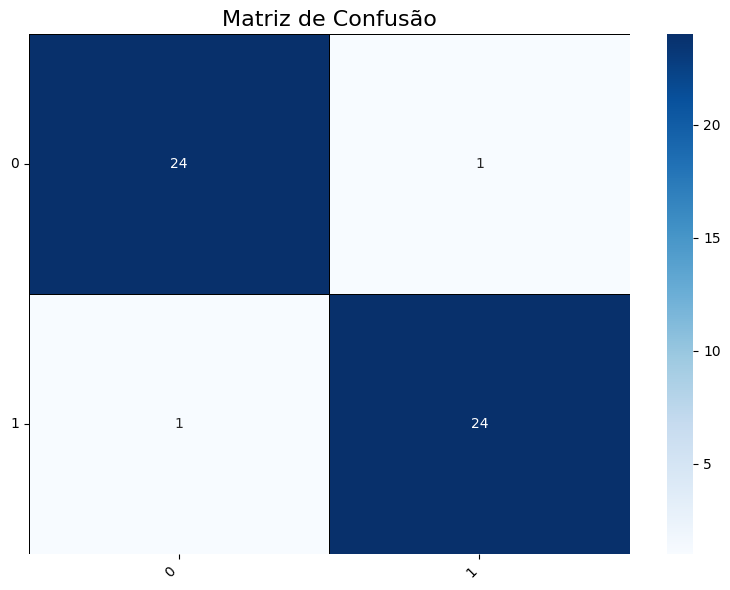

In [3]:
print("\n--- Avaliando o Modelo Podado ---")

pruning_model = utils.load_model_from_file("resnet18_cifake_pruned.pth")
validate(test_loader, pruning_model, cross_entropy_function)

### Análise dos resultados: Fine-tunning + Prunning

## Extra: Adicionando quantização simples com .half()

In [ ]:
# Modelo Podado
pruning_model_half = utils.load_model_from_file("resnet18_cifake_pruned.pth").half()
print("Modelo quantizado pronto para avaliação de desempenho.")
for name, param in pruning_model_half.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.dtype}")

c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Modelo original 'resnet18_cifake_pruned.pth' carregado para avaliação de desempenho.
Modelo quantizado pronto para avaliação de desempenho.
conv1.weight: torch.float16
bn1.weight: torch.float16
bn1.bias: torch.float16
layer1.0.conv1.weight: torch.float16
layer1.0.bn1.weight: torch.float16
layer1.0.bn1.bias: torch.float16
layer1.0.conv2.weight: torch.float16
layer1.0.bn2.weight: torch.float16
layer1.0.bn2.bias: torch.float16
layer1.1.conv1.weight: torch.float16
layer1.1.bn1.weight: torch.float16
layer1.1.bn1.bias: torch.float16
layer1.1.conv2.weight: torch.float16
layer1.1.bn2.weight: torch.float16
layer1.1.bn2.bias: torch.float16
layer2.0.conv1.weight: torch.float16
layer2.0.bn1.weight: torch.float16
layer2.0.bn1.bias: torch.float16
layer2.0.conv2.weight: torch.float16
layer2.0.bn2.weight: torch.float16
layer2.0.bn2.bias: torch.float16
layer2.0.downsample.0.weight: torch.float16
layer2.0.downsample.1.weight: torch.float16
layer2.0.downsample.1.bias: torch.float16
layer2.1.conv1.weight

In [ ]:
# --- Configurar Input de Teste ---
dummy_input_inference = torch.randn(1, 3, 224, 224) # Um único input para medir a latência

# --- Realizar as Medições e Imprimir Resultados ---
print("\n--- Resultados de Eficiência do Modelo ---")

time_original = utils.measure_inference_time(model, dummy_input_inference)
mem_original = utils.measure_model_memory_usage(model)
print(f"\nModelo Original (Resnet18 + Fine-tunning):")
print(f"  Tamanho (parâmetros em memória): {mem_original:.2f} MB")
print(f"  Tempo médio de inferência (1 imagem): {time_original:.3f} ms")

# Medição do Modelo Podado
time_pruned = utils.measure_inference_time(pruning_model, dummy_input_inference)
mem_pruned = utils.measure_model_memory_usage(pruning_model)
print(f"\nModelo Podado (Float32):")
print(f"  Tamanho (parâmetros em memória): {mem_pruned:.2f} MB")
print(f"  Tempo médio de inferência (1 imagem): {time_pruned:.3f} ms")


time_comparasion = ((time_original - time_pruned) / time_original) * 100
mem_comparasion = ((mem_original - mem_pruned) / mem_original) * 100
print(f"  Redução no tempo de inferência (Podado vs Original): {time_comparasion:.2f}%")
print(f"  Redução no uso de memória (Podado vs Original): {mem_comparasion:.2f}%") 
